### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import tensorflow 
import os
import glob
import tqdm

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline 

### IMPORT / VIEWING / PREPROCESSING DATASET

In [2]:
# Training Data

alluvial_soil = os.listdir('../input/soil-classification-image-data/Soil_Dataset/Train/Alluvial_Soil/')
black_soil    = os.listdir('../input/soil-classification-image-data/Soil_Dataset/Train/Black_Soil/')
clay_soil     = os.listdir('../input/soil-classification-image-data/Soil_Dataset/Train/Clay_Soil/')
red_soil      = os.listdir('../input/soil-classification-image-data/Soil_Dataset/Train/Red_Soil/')

In [3]:
a, b, c, d = len(alluvial_soil), len(black_soil), len(clay_soil), len(red_soil)
e = a + b + c + d
print("Total images: ", e)

Total images:  715


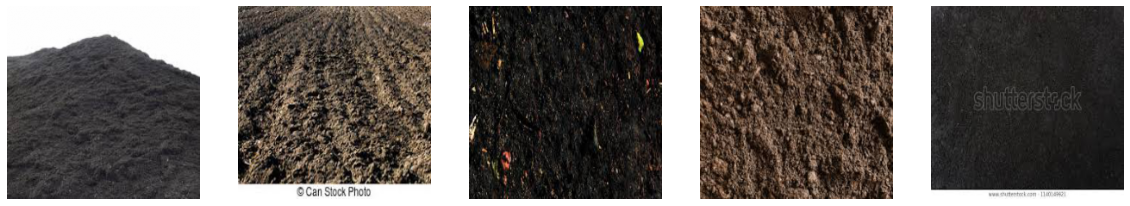

In [4]:
# Viewing - Black Soil 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(black_soil)) 
    img  = imread('../input/soil-classification-image-data/Soil_Dataset/Train/Black_Soil/' + black_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

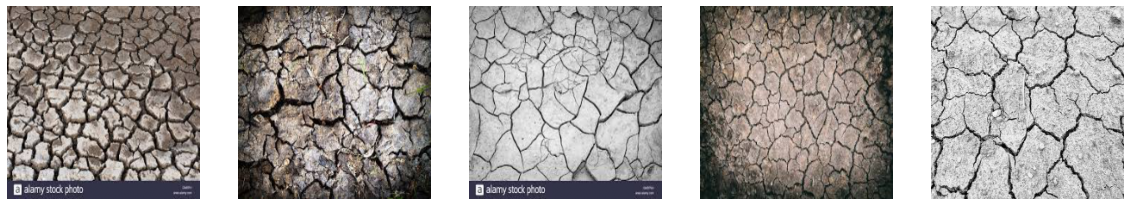

In [5]:
# Viewing - Clay Soil 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(clay_soil)) 
    img  = imread('../input/soil-classification-image-data/Soil_Dataset/Train/Clay_Soil/' + clay_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

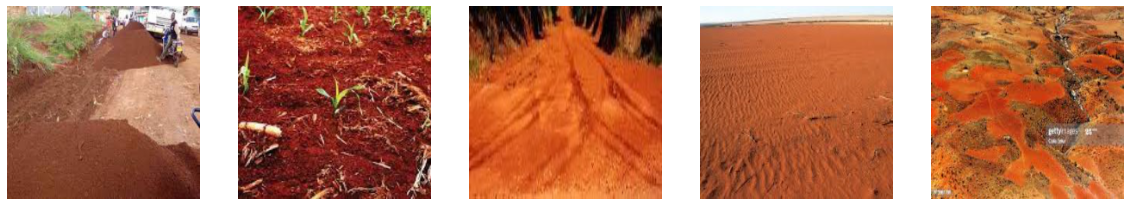

In [6]:
# Viewing - Red Soil 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(red_soil)) 
    img  = imread('../input/soil-classification-image-data/Soil_Dataset/Train/Red_Soil/' + red_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

**`DATA AUGMENTATION`**

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale=1./255)

In [26]:
train_dataset = train_datagen.flow_from_directory(directory = '../input/soil-classification-image-data/Soil_Dataset/Train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 715 images belonging to 4 classes.


In [27]:
test_datset = test_datagen.flow_from_directory(directory = '../input/soil-classification-image-data/Soil_Dataset/Test',
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               batch_size = 64)

Found 188 images belonging to 4 classes.


### MODEL BUILDING 

> `MODEL INITIALIZATION`

In [31]:
model = Sequential()

> `BUILDING LAYERS`

In [32]:
# Input Layer 
model.add(InputLayer(input_shape = (224,224,3)))


# Layers
model.add(Conv2D(filters = 32,  kernel_size  = (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,  kernel_size  = (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))


# Flatten()
model.add(Flatten())


# Full Connected Layer 
model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Output layer 
model.add(Dense(units = 4, activation = 'softmax'))

> `MODEL SUMMARY`

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)       

> `MODEL COMPILE`

In [34]:
model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

> `DEFINING CALLBACKS`

In [35]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 1,
                                  factor = 0.1,
                                  min_delta = 1e-5,
                                  patience = 3)

callback_list = [earlystopping, checkpoint, learning_rate]

> `MODEL RUNNING`

In [36]:
model_history = model.fit(train_dataset,
                          validation_data = test_datset,
                          epochs = 500,
                          verbose = 1,
                          callbacks = callback_list)

Epoch 1/500
12/12 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.7147
Epoch 00001: val_accuracy improved from -inf to 0.26064, saving model to ./best_weights.hdf5
12/12 [==============================] - 14s 1s/step - loss: 0.7596 - accuracy: 0.7147 - val_loss: 1.3589 - val_accuracy: 0.2606
Epoch 2/500
12/12 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7972
Epoch 00002: val_accuracy did not improve from 0.26064
12/12 [==============================] - 12s 1s/step - loss: 0.5465 - accuracy: 0.7972 - val_loss: 1.4801 - val_accuracy: 0.2553
Epoch 3/500
12/12 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8545
Epoch 00003: val_accuracy did not improve from 0.26064
12/12 [==============================] - 12s 1s/step - loss: 0.3933 - accuracy: 0.8545 - val_loss: 1.6052 - val_accuracy: 0.2553
Epoch 4/500
12/12 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8671
Epoch 00004: val_accuracy did 